In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train1 = pd.read_csv('../Input_Data/e-SNLI/dataset/esnli_train_1.csv')
train2 = pd.read_csv('../Input_Data/e-SNLI/dataset/esnli_train_2.csv')
train = pd.concat([train1, train2])
train = train[train.notnull().apply(all, axis=1)]
dev = pd.read_csv('../Input_Data/e-SNLI/dataset/esnli_dev.csv')
dev = dev[dev.notnull().apply(all, axis=1)]
test = pd.read_csv('../Input_Data/e-SNLI/dataset/esnli_test.csv')
test = test[test.notnull().apply(all, axis=1)]

In [3]:
dev_prepared = pd.read_pickle("../02_Extract_Subphrases/prepared_data/subphrase_vectors_dev.pkl")

In [4]:
dev_prepared.head()

,pairID,string_subj_s1,string_verb_s1,string_obj_s1,string_loc_s1,string_clo_s1,string_subj_s2,string_verb_s2,string_obj_s2,string_loc_s2,string_clo_s2,vecs
0,4705552913.jpg#2r1n,Two women,embracing,,,,The sisters,hugging,goodbye,,,"[4705552913.jpg#2r1n, -9.865991, -1.9091997, 0..."
1,4705552913.jpg#2r1e,Two women,embracing,,,,Two woman,holding,packages,,,"[4705552913.jpg#2r1e, -9.865991, -1.9091997, 0..."
2,4705552913.jpg#2r1c,Two women,embracing,,,,The men,fighting,,,,"[4705552913.jpg#2r1c, -9.865991, -1.9091997, 0..."
3,2407214681.jpg#0r1e,"Two young children in ,",standing,,in blue jerseys,,Two kids in numbered jerseys,wash,their hands,in numbered jerseys,,"[2407214681.jpg#0r1e, -16.48036, -2.7041402, -..."
4,2407214681.jpg#0r1n,"Two young children in ,",standing,,in blue jerseys,,Two kids at a ballgame,wash,their hands,,,"[2407214681.jpg#0r1n, -16.48036, -2.7041402, -..."


In [5]:
data = pd.DataFrame([vec for vec in dev_prepared.vecs if vec is not None])
data_index = data.iloc[:,0]
data = data.iloc[:,1:].to_numpy().astype(float)

In [6]:
dev = dev.set_index('pairID')
dev_prepared = dev_prepared.set_index('pairID')

In [7]:
from scipy.stats import kstest

KstestResult(statistic=0.13066417064069258, pvalue=9.579269644254027e-131, statistic_location=0.11036775054147842, statistic_sign=-1)

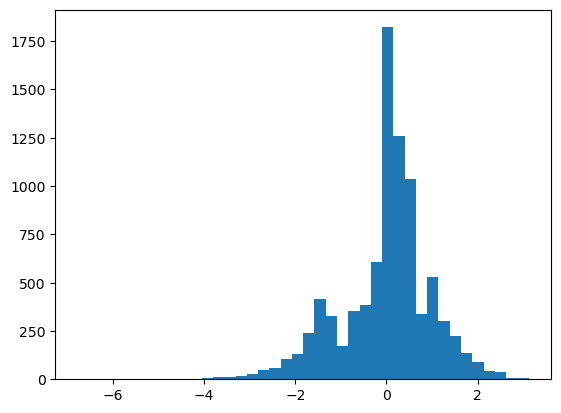

In [8]:
temp = data[~np.isnan(data[:,0]),0]
temp = temp - temp.mean()
temp = temp / temp.std()
plt.hist(temp, bins=40)
kstest(temp,"norm")

In [261]:
#data = np.stack(np.vectorize(lambda x: 0 if x == 'nan' else x)(data), axis=1).T

In [9]:
from sklearn.neural_network import MLPClassifier

In [10]:
clf = list()
for i in range(25):
    clf += [MLPClassifier(hidden_layer_sizes=(25, 25, 10)), ]

In [11]:
res = list()
y_hat = list()
for ind in data_index:
    label = dev.loc[ind].gold_label
    y_hat += [label, ]
    if label == "neutral":
        res += [["neutral", ] * 25, ]
    elif label == "entailment":
        temp_ent = ["neutral", ] * 25
        temp_ent = ["entailment" if i in np.random.choice(range(25), size=np.random.randint(1,25), replace=False) else temp_ent[i] for i in range(25)]
        res += [temp_ent, ]
    else:
        temp_contr = list(np.random.choice(["entailment", "neutral"], size=25))
        temp_contr = ["contradiction" if i in np.random.choice(range(25), size=np.random.randint(1,25), replace=False) else temp_contr[i] for i in range(25)]
        res += [temp_contr, ]
z_dev = np.array(res)
y_hat = np.array(y_hat)

In [12]:
z_dev.shape

(8792, 25)

In [13]:
indices = [[0,1500], [0,1800], [0,2100], [0,2400], [0,2700],
 [300,1500], [300,1800], [300,2100], [300,2400], [300,2700],
 [600,1500], [600,1800], [600,2100], [600,2400], [600,2700],
 [900,1500], [900,1800], [900,2100], [900,2400], [900,2700],
 [1200,1500], [1200,1800], [1200,2100], [1200,2400], [1200,2700]]

In [14]:
not_nan = [None, ] * 25
cols = [None, ] * 25
for i in range(25):
    cols[i] = list(range(indices[i][0], indices[i][0]+300)) + list(range(indices[i][1],indices[i][1]+300))
    not_nan[i] = pd.Series([not x for x in pd.DataFrame(np.isnan(data[:,cols[i]])).apply(any, axis=1)])
not_nan = np.array(not_nan).T

In [19]:
for i in range(25):
    clf[i].fit(data[not_nan[:,i],][:,cols[i]], z_dev[not_nan[:,i], i])

/Users/marcbraun/.conda/envs/master_thesis_code/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/marcbraun/.conda/envs/master_thesis_code/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/marcbraun/.conda/envs/master_thesis_code/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/marcbraun/.conda/envs/master_thesis_code/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

In [15]:
def check_if_pred_is_possible(pred, actual):
    if actual == "neutral":
        return "neutral"
    elif actual == "entailment" and pred == "contradiction":
        return list(np.random.choice(["entailment", "neutral"], size=1))[0]
    else:
        return pred

In [24]:
def predict_y_from_z(z):
    if len(z.shape) > 1:
        return np.apply_along_axis(predict_y_from_z, axis=1, arr=z)
    else:
        if all([z_dev[1, i] == 'nan' or z_dev[1, i] == 'neutral' for i in range(25)]):
            return 'neutral'
        elif any(z == 'contradiction'):
            return 'contradiction'
        else:
            return 'entailment'

In [27]:
num_iter = 1
for j in range(num_iter):
    for i in range(25):
        cols = list(range(indices[i][0], indices[i][0]+300)) + list(range(indices[i][1],indices[i][1]+300))
        not_nan = pd.Series([not x for x in pd.DataFrame(np.isnan(data[:,cols])).apply(any, axis=1)])
        #preds = pd.Series(clf[i].predict(data[not_nan,:][:,list(range(indices[i][0], indices[i][0]+300)) + list(range(indices[i][1],indices[i][1]+300))]))
        #preds = pd.Series([check_if_pred_is_possible(pred=preds[k], actual=y_hat[not_nan][k]) for k in range(preds.shape[0])])
        #z_dev[not_nan, i] = preds
        #y_preds = predict_y_from_z(z_dev[not_nan, :])
        #s = pd.Series(y_preds != y_hat[not_nan])
        #print(s.mean())
        #preds[s] = y_hat[not_nan][s]
        z_dev[pd.Series([not x for x in not_nan]), i] = np.nan
        #clf[i].fit(data[not_nan,][:,cols], preds)

In [9]:
# Source: https://stackoverflow.com/questions/6284396/permutations-with-unique-values
class unique_element:
    def __init__(self,value,occurrences):
        self.value = value
        self.occurrences = occurrences

def perm_unique(elements):
    eset=set(elements)
    listunique = [unique_element(i,elements.count(i)) for i in eset]
    u=len(elements)
    return perm_unique_helper(listunique,[0]*u,u-1)

def perm_unique_helper(listunique,result_list,d):
    if d < 0:
        yield tuple(result_list)
    else:
        for i in listunique:
            if i.occurrences > 0:
                result_list[d]=i.value
                i.occurrences-=1
                for g in  perm_unique_helper(listunique,result_list,d-1):
                    yield g
                i.occurrences+=1

In [86]:
def calc_log_prob(z, clf, data):
    log_prob = [None, ] * 25
    for i in range(25):
        res = pd.DataFrame([[0, ] * z.shape[0], ] * 3).T
        res[not_nan[:,i]] = clf[i].predict_log_proba(data[not_nan[:, i],:][:,list(range(indices[i][0], indices[i][0]+300)) + list(range(indices[i][1],indices[i][1]+300))])
        log_prob[i] = res
    log_prob = np.stack(log_prob, axis=0)
    return log_prob

In [41]:
def find_possible_configs():
    max_i = 25 + 1
    res = list()
    for y_hat in ('contradiction', 'entailment', 'neutral'):
        perms = list()
        print(y_hat)
        if y_hat == 'neutral':
            perms = [['neutral', ] * 25, ]
        elif y_hat == 'contradiction':
            for i in range(1, max_i):
                for j in range(0, max_i - i):
                    perms += [['contradiction', ] * i + ['neutral', ] * j + ['entailment', ] * (max_i-1 - i - j), ]
        elif y_hat == 'entailment':
            for i in range(1, max_i):
                perms += [['entailment', ] * i + ['neutral', ] * (max_i - i), ]
        temp = [list(perm_unique(perm)) for perm in perms[:8]]
        temp = [i for t in temp for i in t]
        res += [temp, ]
    return {'contradiction': res[0], 'entailment': res[1], 'neutral': res[2]}

def get_log_prob(config, config_map, log_prob):
    return np.sum([log_prob[i,config_map[cur_config]] for i, cur_config in enumerate(config)])

def find_most_likely_z(log_prob, possible_configs, y_hat):
    config_map = {'contradiction': 0, 'entailment': 1, 'neutral': 2}
    config_log_prob = list()
    j = 0
    for possible_config in possible_configs[y_hat]:
        j += 1
        for i in range(25):
            config_log_prob[j,i] = [np.sum([log_prob[i,config_map[cur_val]] for cur_val in possible_config]), ]
    z = possible_configs[np.argmax(config_log_prob[j,:])]
    return z

def most_likely_heuristic(clf, y_hat, data, not_nan):
    y_mapping = {clf[0].classes_[0]: 0, clf[0].classes_[1]: 1, clf[0].classes_[2]: 2}
    preds = pd.Series([np.nan, ] * 25)
    for i in range(25):
        if not_nan[i]:
            preds[i] = clf[i].predict(data[cols[i]].reshape(1,-1))[0]
    predicted_y = predict_y_from_z(preds)
    log_prob = np.zeros((25,3))
    for i in range(25):
        if not_nan[i]:
            log_prob[i,:] = clf[i].predict_log_proba(data[cols[i]].reshape(1,-1))
    if predicted_y != y_hat:
        if y_hat == 'neutral':
            preds[not_nan] = 'neutral'
        elif y_hat == 'contradiction':
            best_i = 0
            best_swapping_cost = np.inf
            for i in range(25):
                if not_nan[i]:
                    swapping_cost = log_prob[i,y_mapping[preds[i]]] - log_prob[i,y_mapping['contradiction']]
                    if swapping_cost < best_swapping_cost:
                        best_i = i
            preds[best_i] = 'contradiction'
        elif y_hat == 'entailment':
            if predicted_y == 'contradiction':
                for i in np.where(pd.Series(preds) == 'contradiction'):
                    i = i[0]
                    replace_with_entailment = False
                    if not_nan[i]:
                        swapping_cost_ent = log_prob[i, y_mapping[preds[i]]] - log_prob[i][y_mapping['entailment']]
                        swapping_cost_neutr = log_prob[i, y_mapping[preds[i]]] - log_prob[i,y_mapping['neutral']]
                        if swapping_cost_neutr > swapping_cost_ent:
                            preds[i] = 'entailment'
                            replace_with_entailment = True
                        else:
                            preds[i] = 'neutral'
            if not replace_with_entailment:
                best_i = 0
                best_swapping_cost = np.inf
                for i in range(25):
                    if not_nan[i]:
                        swapping_cost = log_prob[i, y_mapping[preds[i]]] - log_prob[i, y_mapping['entailment']]
                        if swapping_cost < best_swapping_cost:
                            best_i = i
                preds[best_i] = 'entailment'
    log_lik = 0
    for i in range(25):
        if not_nan[i]:
            log_lik += log_prob[i, y_mapping[preds[i]]]
    return preds, log_lik

In [42]:
def estimate_z_and_log_lik(clf, y_hat, data, not_nan):
    res = list()
    log_lik = 0
    for i in range(data.shape[0]):
        preds, cur_log_lik = most_likely_heuristic(clf, y_hat[i], data[i,:], not_nan[i,:])
        res += [preds, ]
        log_lik += cur_log_lik
    return np.array(res), log_lik

In [43]:
def em_algorithm(clf, y_hat, data, not_nan, iter):
    log_lik = list()
    for k in range(iter):
        # E-Step
        z, cur_log_lik = estimate_z_and_log_lik(clf, y_hat, data, not_nan)
        log_lik += [cur_log_lik, ]
        # M-Step
        for i in range(25):
            clf[i].fit(data[not_nan[:,i],][:,cols[i]], z[not_nan[:,i], i])

    return clf, z, log_lik

In [48]:
clf, z, log_lik = em_algorithm(clf, y_hat, data, not_nan, 10)

/Users/marcbraun/.conda/envs/master_thesis_code/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/marcbraun/.conda/envs/master_thesis_code/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/marcbraun/.conda/envs/master_thesis_code/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/marcbraun/.conda/envs/master_thesis_code/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reac

Text(0.5, 1.0, 'Log Likelihood EM-Algorithm')

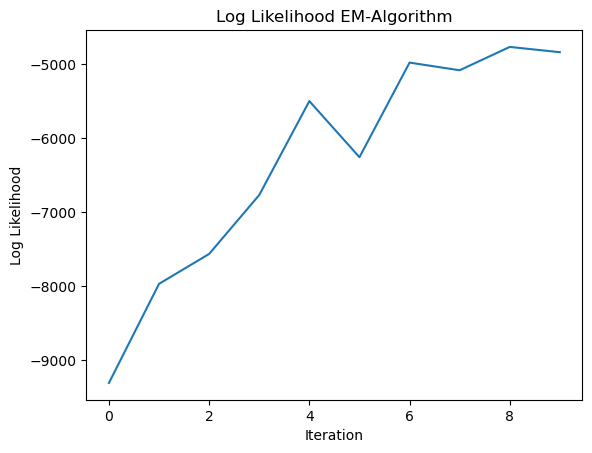

In [56]:
plt.plot(log_lik)
plt.xlabel('Iteration')
plt.ylabel('Log Likelihood')
plt.title('Log Likelihood EM-Algorithm')

In [50]:
z

array([['neutral', 'neutral', 'neutral', ..., nan, nan, nan],
       ['neutral', 'neutral', 'neutral', ..., nan, nan, nan],
       ['neutral', 'neutral', nan, ..., nan, nan, nan],
       ...,
       ['neutral', 'neutral', nan, ..., nan, nan, nan],
       ['neutral', 'neutral', 'neutral', ..., 'neutral', nan,
        'entailment'],
       ['neutral', 'neutral', 'neutral', ..., 'neutral', nan, nan]],
      dtype=object)

In [51]:
dev_prepared

,string_subj_s1,string_verb_s1,string_obj_s1,string_loc_s1,string_clo_s1,string_subj_s2,string_verb_s2,string_obj_s2,string_loc_s2,string_clo_s2,vecs
pairID,,,,,,,,,,,
4705552913.jpg#2r1n,Two women,embracing,,,,The sisters,hugging,goodbye,,,"[4705552913.jpg#2r1n, -9.865991, -1.9091997, 0..."
4705552913.jpg#2r1e,Two women,embracing,,,,Two woman,holding,packages,,,"[4705552913.jpg#2r1e, -9.865991, -1.9091997, 0..."
4705552913.jpg#2r1c,Two women,embracing,,,,The men,fighting,,,,"[4705552913.jpg#2r1c, -9.865991, -1.9091997, 0..."
2407214681.jpg#0r1e,"Two young children in ,",standing,,in blue jerseys,,Two kids in numbered jerseys,wash,their hands,in numbered jerseys,,"[2407214681.jpg#0r1e, -16.48036, -2.7041402, -..."
2407214681.jpg#0r1n,"Two young children in ,",standing,,in blue jerseys,,Two kids at a ballgame,wash,their hands,,,"[2407214681.jpg#0r1n, -16.48036, -2.7041402, -..."
...,...,...,...,...,...,...,...,...,...,...,...
77063034.jpg#3r1e,A small girl,wearing,a pink jacket,on a carousel,pink jacket,The carousel,moving,,,,"[77063034.jpg#3r1e, -6.2690387, 10.356, -1.708..."
77063034.jpg#3r1c,A small girl,wearing,a pink jacket,on a carousel,pink jacket,The girl,moving,,,,"[77063034.jpg#3r1c, -6.2690387, 10.356, -1.708..."
4805835848.jpg#0r1e,a zebra skirt,wading,,in her braids,white t skirt shirt,,,,in a water fountain,,None


In [5]:
temp = pd.read_csv("../02_Extract_Subphrases/prepared_data/subphrase_vectors_440train.csv", delimiter=";")

In [25]:
temp = temp.iloc[:,1:]

In [27]:
data_index = temp.iloc[:,0]

In [21]:
temp.set_index("0")

,Unnamed: 0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,3000
0,,,,,,,,,,,,,,,,,,,,,
2727591060.jpg#2r4c,0,-22.526200,13.94376,-7.4768,4.78921,26.454199,-5.06810,-2.66827,18.40840,30.82560,...,4.81580,-1.9727,6.81181,3.16075,-9.47080,0.4436,-6.005650,10.932199,-10.1181,6.03298
2727591060.jpg#2r1n,1,-22.526200,13.94376,-7.4768,4.78921,26.454199,-5.06810,-2.66827,18.40840,30.82560,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2727591060.jpg#2r4e,2,-22.526200,13.94376,-7.4768,4.78921,26.454199,-5.06810,-2.66827,18.40840,30.82560,...,4.81580,-1.9727,6.81181,3.16075,-9.47080,0.4436,-6.005650,10.932199,-10.1181,6.03298
4584895948.jpg#4r1n,3,-2.680300,-0.04581,-2.7613,0.79493,0.639890,0.92164,-2.59970,-4.00820,-2.08440,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4584895948.jpg#4r1c,4,-2.680300,-0.04581,-2.7613,0.79493,0.639890,0.92164,-2.59970,-4.00820,-2.08440,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288038357.jpg#0r1e,17683,-7.839800,11.05370,-14.1201,2.65060,11.102960,-8.84410,3.16150,13.92840,7.88531,...,-2.25214,7.7774,5.45630,-1.58120,-3.72620,6.5097,5.216500,3.872900,-3.9956,-2.33127
288038357.jpg#0r1c,17684,-7.839800,11.05370,-14.1201,2.65060,11.102960,-8.84410,3.16150,13.92840,7.88531,...,-4.28624,7.1887,6.68720,1.27860,-3.60959,9.5267,1.511278,3.005200,-2.2091,-1.84089
288038357.jpg#0r1n,17685,-7.839800,11.05370,-14.1201,2.65060,11.102960,-8.84410,3.16150,13.92840,7.88531,...,-2.25214,7.7774,5.45630,-1.58120,-3.72620,6.5097,5.216500,3.872900,-3.9956,-2.33127
